In [90]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import general_functions

In [91]:
def sim_alpha(N: int, steps: int, alpha: float) -> tuple:
    """Two company transactions.

    Args:
        steps (int): System iterations
        alpha (float): Money to production efficiency parameter

    Returns:
        tuple: history of p and m values for both companies
    """
    # Initial m and p values and history arrays
    p = np.ones(N)
    m = np.ones(N)
    p_hist = np.empty((N, steps))
    m_hist = np.empty((N, steps))
    p_hist[:, 0] = p
    m_hist[:, 0] = m

    for i in range(1, steps):
        # Choose seller and buyer
        buyer = np.random.randint(low=0, high=N)
        available_seller = np.arange(0, N)[np.arange(0, N) != buyer]
        seller = np.random.choice(a=available_seller)
        
        # Make transaction
        delta_m = np.min(np.array([p[seller], m[buyer]]))
        m[seller] += delta_m
        m[buyer] -= delta_m
        p[buyer] += alpha * delta_m 
        
        # Update history
        p_hist[:, i] = p * 1
        m_hist[:, i] = m * 1
        
    # Calculate mean values
    p_mean = np.mean(a=p_hist, axis=0)
    m_mean = np.mean(a=m_hist, axis=0)
    
    return p_mean, m_mean


def sim_alpha_delta(N, steps, alpha, delta):
    """Two company transactions.

    Args:
        steps (int): System iterations
        alpha (float): Money to production efficiency parameter

    Returns:
        tuple: history of p and m values for both companies
    """
    # Initial m and p values and history arrays
    p = np.ones(N)
    m = np.ones(N)
    p_hist = np.empty((N, steps))
    m_hist = np.empty((N, steps))
    p_hist[:, 0] = p
    m_hist[:, 0] = m

    for i in range(1, steps):
        # Choose seller and buyer
        buyer = np.random.randint(low=0, high=N)
        available_seller = np.arange(0, N)[np.arange(0, N) != buyer]
        seller = np.random.choice(a=available_seller)
        
        # Make transaction
        delta_m = np.min(np.array([p[seller], m[buyer]]))
        m[seller] += delta_m
        m[buyer] -= delta_m
        p[buyer] += alpha * delta_m 
        p[seller] -= delta * delta_m
        
        # Update history
        p_hist[:, i] = p * 1
        m_hist[:, i] = m * 1
    
    # Calculate mean values
    p_mean = np.mean(a=p_hist, axis=0)
    m_mean = np.mean(a=m_hist, axis=0)
    
    return p_mean, m_mean


def alpha_mean_of_means(repeats, N, steps, alpha):
    p_means_list = np.empty((steps, repeats))
    m_means_list = np.empty((steps, repeats))
    
    # Simulate repeats times
    for i in range(repeats):
        p_mean, m_mean = sim_alpha(N, steps, alpha)
        p_means_list[:, i] = p_mean
        m_means_list[:, i] = m_mean
    
    # Calculate mean of means
    p_means = np.mean(p_means_list, axis=1)
    m_means = np.mean(m_means_list, axis=1)
    p_std = np.std(p_means_list, axis=1)
    m_std = np.std(m_means_list, axis=1)
    
    return p_means, m_means, p_std, m_std


def alpha_delta_mean_of_means(repeats, N, steps, alpha, delta):
    p_means_list = np.empty((steps, repeats))
    m_means_list = np.empty((steps, repeats))
    
    # Simulate repeats times
    for i in range(repeats):
        p_mean, m_mean = sim_alpha_delta(N, steps, alpha, delta)
        p_means_list[:, i] = p_mean
        m_means_list[:, i] = m_mean
    
    # Calculate mean of means
    p_means = np.mean(p_means_list, axis=1)
    m_means = np.mean(m_means_list, axis=1)
    p_std = np.std(p_means_list, axis=1)
    m_std = np.std(m_means_list, axis=1)
    
    return p_means, m_means, p_std, m_std

In [95]:
def linear(x, a, b):
    return a * x + b


def plot(repeats, N, steps, alpha_a, alpha_ad, delta):
    # Get data
    p_a, m_a, p_std_a, m_std_a = alpha_mean_of_means(repeats, N, steps, alpha_a)
    p_ad, m_ad, p_std_ad, m_std_ad = alpha_delta_mean_of_means(repeats, N, steps, alpha_ad, delta)
    time = np.arange(steps)
    
    # Only include every 10'th point
    p_a = p_a[::10]
    p_ad = p_ad[::10]
    std_p_a = std_p_a[::10]
    std_p_ad = std_p_ad[::10]
    
    # Calculate linear data
    offset_a = p_a[0]
    offset_ad = p_ad[0]
    slope_a = alpha_a / N -  offset_a / steps
    slope_ad = (alpha_ad - delta) / N - offset_ad / steps
    
    linear_a = linear(time, slope_a, b=offset_a)
    linear_ad = linear(time, slope_ad, b=offset_ad)
    
    # Create figure
    fig, (ax, ax1) = plt.subplots(nrows=2)
    
    # Alpha sim
    ax.errorbar(time, p_a, yerr=p_std_a)
    # ax.errorbar(time, m_a, yerr=m_std_a, c="black")
    ax.plot(time, linear_a, ls="dashed")
    
    # Alpha-delta sim
    ax1.errorbar(time, p_ad, yerr=p_std_ad)
    # ax1.errorbar(time, m_ad, yerr=m_std_ad, c="black")
    ax1.plot(time, linear_ad, ls="dashed")
    
    # Axis setup
    ax.set(ylabel="$", title=fr"$\alpha = {alpha_a}$")
    ax1.set(ylabel="$", xlabel="Time steps", title=fr"$\alpha = {alpha_ad}, \delta = {delta}$")
    
    # Grids
    ax.grid()
    ax1.grid()
    
    # Legend
    legend_elements = [Line2D([], [], color="rebeccapurple", label="Production"),
                        Line2D([], [], color="black", label="Money"),
                        Line2D([], [], color="firebrick", label="y=ax + b", linestyle="dashed")]
    fig.subplots_adjust(hspace=0.55)
    fig.legend(handles=legend_elements, ncols=3, bbox_to_anchor=(0.5, 0.45), loc="lower center")
    
    fig.suptitle(r"$\alpha$ vs $\alpha - \delta$")
    plt.show()

In [105]:
def linear(x, a, b):
    return a * x + b


def plot(repeats, N, steps, alpha_a, alpha_ad, delta):
    # Get data
    p_a, m_a, p_std_a, m_std_a = alpha_mean_of_means(repeats, N, steps, alpha_a)
    p_ad, m_ad, p_std_ad, m_std_ad = alpha_delta_mean_of_means(repeats, N, steps, alpha_ad, delta)
    time = np.arange(steps)
    
    # Only include every 10'th point
    p_a = p_a[::10]
    p_ad = p_ad[::10]
    p_std_a = p_std_a[::10]
    p_std_ad = p_std_ad[::10]
    time = time[::10]
    
    
    # Calculate linear data
    offset_a = p_a[0]
    offset_ad = p_ad[0]
    slope_a = alpha_a / N -  offset_a / steps
    slope_ad = (alpha_ad - delta) / N - offset_ad / steps
    
    linear_a = linear(time, slope_a, b=offset_a)
    linear_ad = linear(time, slope_ad, b=offset_ad)
    
    # Create figure
    fig, (ax, ax1) = plt.subplots(nrows=2)
    
    # Alpha sim
    ax.errorbar(time, p_a, yerr=p_std_a)
    # ax.errorbar(time, m_a, yerr=m_std_a, c="black")
    ax.plot(time, linear_a, ls="dashed")
    
    # Alpha-delta sim
    ax1.errorbar(time, p_ad, yerr=p_std_ad)
    # ax1.errorbar(time, m_ad, yerr=m_std_ad, c="black")
    ax1.plot(time, linear_ad, ls="dashed")
    
    # Axis setup
    ax.set(ylabel="$", title=fr"$\alpha = {alpha_a}$")
    ax1.set(ylabel="$", xlabel="Time steps", title=fr"$\alpha = {alpha_ad}, \delta = {delta}$")
    
    # Grids
    ax.grid()
    ax1.grid()
    
    # Legend
    legend_elements = [Line2D([], [], color="rebeccapurple", label="Production"),
                        # Line2D([], [], color="black", label="Money"),
                        Line2D([], [], color="firebrick", label="y=ax + b", linestyle="dashed")]
    fig.subplots_adjust(hspace=0.55)
    fig.legend(handles=legend_elements, ncols=3, bbox_to_anchor=(0.2, 0.85), loc="lower center")
    
    fig.suptitle(r"$\alpha$ vs $\alpha - \delta$")
    plt.show()

C:\Users\tobia\AppData\Local\Temp\ipykernel_44928\709981730.py:53: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.55)


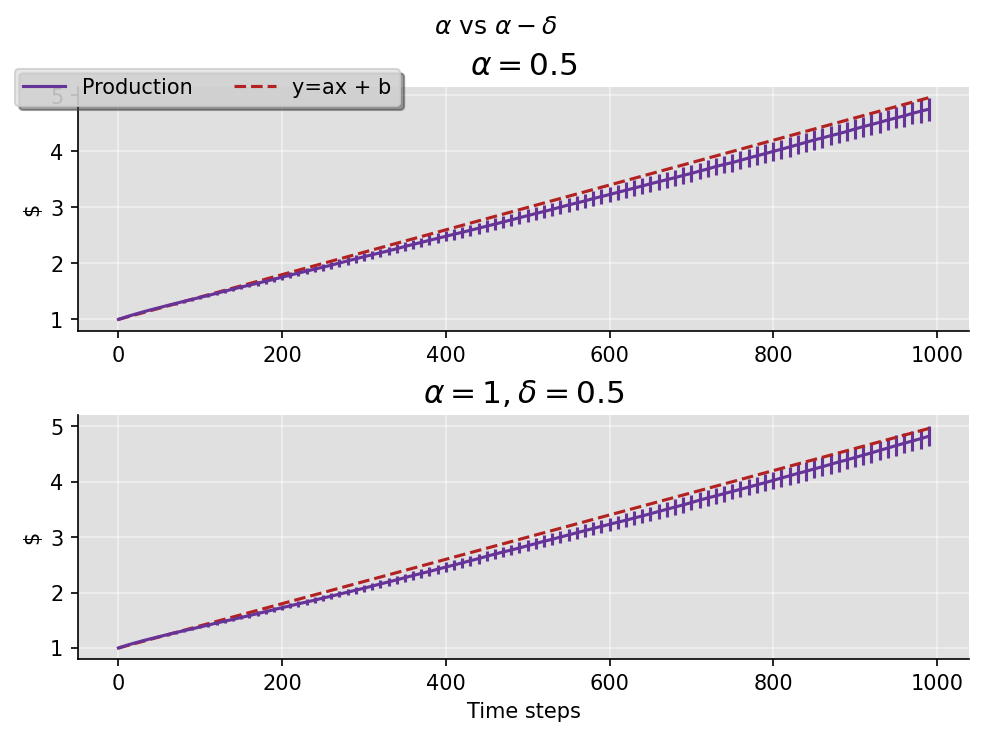

In [106]:
plot(repeats=100, N=100, steps=1000, alpha_a=0.5, alpha_ad=1, delta=0.5)

Man kunne se på fordelingen af y-værdier og sammenligne de to fordelinger